# Zindi  Insurance Prediction

https://zindi.africa/competitions/data-science-nigeria-2019-challenge-1-insurance-prediction/data

In [1]:
# отключение ворнингов
import warnings
warnings.filterwarnings('ignore')
# импорт библиотек
import numpy as np
import os
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
# настройки отображения строк и столбцов в пандас
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

# настройка размеров графиков
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)
sns.set(style='whitegrid', rc={'figure.figsize':(12, 8), 'lines.linewidth': 3})


# настройка стиля графиков
plt.style.use('ggplot')
sns.set_style('whitegrid')

Populating the interactive namespace from numpy and matplotlib


## 0. Чтение и проверка данных

In [3]:
# чтение данных
df = pd.read_csv(os.path.join('data', 'train_data.csv'))
df.head(5)

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
0,H14663,2013,1.0,0,N,V,V,U,290.0,1,1960.0,.,1053,0
1,H2037,2015,1.0,0,V,N,O,R,490.0,1,1850.0,4,1053,0
2,H3802,2014,1.0,0,N,V,V,U,595.0,1,1960.0,.,1053,0
3,H3834,2013,1.0,0,V,V,V,U,2840.0,1,1960.0,.,1053,0
4,H5053,2014,1.0,0,V,N,O,R,680.0,1,1800.0,3,1053,0


In [4]:
# выведу долю пропусков по столбцам

def missing_values(data):
    """
    Returns columns with missing values
    :param data: pandas DataFrame
    """
    missing = pd.DataFrame(df.isnull().sum())
    missing['% of Total Values'] = 100 * df.isnull().sum() / len(df)
    missing.rename(columns = {0 : 'Missing Values'}, inplace=True)
    missing.sort_values(by='% of Total Values', ascending=False, inplace=True)
    missing = missing[missing['Missing Values']>0]
    
    if missing.shape[0] == 0:
        print('В данных нет пропусков!')
    else:
        return missing

missing_values(df)

,Missing Values,% of Total Values
Date_of_Occupancy,508,7.094972
Building Dimension,106,1.480447
Geo_Code,102,1.424581
Garden,7,0.097765


Первые 2 заполню средним, остальное удалю, тк не сильно влияет на размер датасета.

In [5]:
def fill_na(data, column, function):
    """
    Fill nan values in pandas series
    :param data: pandas DataFrame
    :param column: column name
    :param function: mean, median, etc.
    """
    data[column].fillna(
        function(data[data[column].isnull() == False][column]),
        inplace=True)

In [6]:
for column in tqdm(['Date_of_Occupancy', 'Building Dimension']):
    fill_na(df, column, np.mean)

100%|██████████| 2/2 [00:00<00:00, 247.83it/s]


In [7]:
# удаляю пропуски
df.dropna(inplace=True)

# удаляю дубли
df.drop_duplicates(inplace=True)

# удаляю признак Customer Id
df.drop('Customer Id', axis=1, inplace=True)

# приведу названия столбцов к нижнему регистру для удобства
df.columns = [str.lower(column) for column in df.columns]

print('Размер датасета после удаления пропусков: {}'.format(df.shape))

Размер датасета после удаления пропусков: (7051, 13)


## 1. Визуальный анализ данных

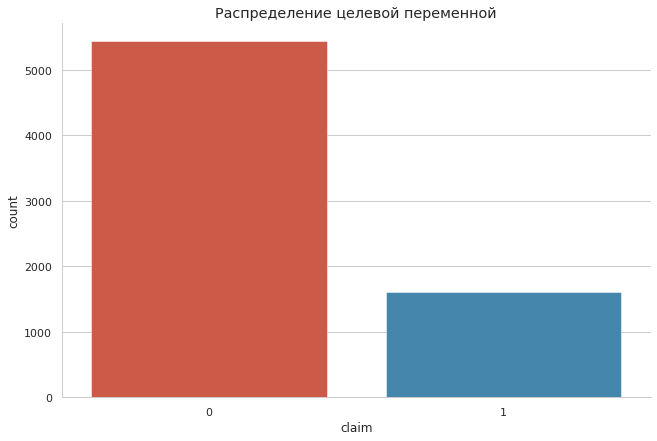

In [8]:

# визуально оценю распределение целевой переменной
sns.catplot(x='claim', kind='count', data=df, orient='v', aspect=1.5, height=6)
plt.title('Распределение целевой переменной');

Целевая метрика соревнования- **ROC-AUC**, поэтому тут выбирать не буду.

In [9]:
# получу списки категориальных и количественных переменных

def get_columns_types(data, target):
    """
    Returns lists of catgorical and numerical columns
    :param data: pandas DataFrame
    :param target: target column, str
    """
    cat, num = list(), list()
    cat = [column for column in data.columns if data[column].dtype == 'object' and column != target]
    num = [column for column in data.columns if column not in cat and column != target]
    
    return cat, num

cat, num = get_columns_types(df, target='claim')

In [10]:
# проверю количество уникальных значений

for feature in num:
    print(f'Уникальных значений в признаке {feature}: {df[feature].nunique()}')

Уникальных значений в признаке yearofobservation: 5
Уникальных значений в признаке insured_period: 394
Уникальных значений в признаке residential: 2
Уникальных значений в признаке building dimension: 2042
Уникальных значений в признаке building_type: 4
Уникальных значений в признаке date_of_occupancy: 135


Видим, что признаки yearofobservation, residential и building_type стоит отнести к категориальным.

In [11]:
# перенесу их в список категориальных
for column in tqdm(['yearofobservation', 'residential', 'building_type']):
    cat.append(column)
    num.remove(column)

100%|██████████| 3/3 [00:00<00:00, 4643.14it/s]


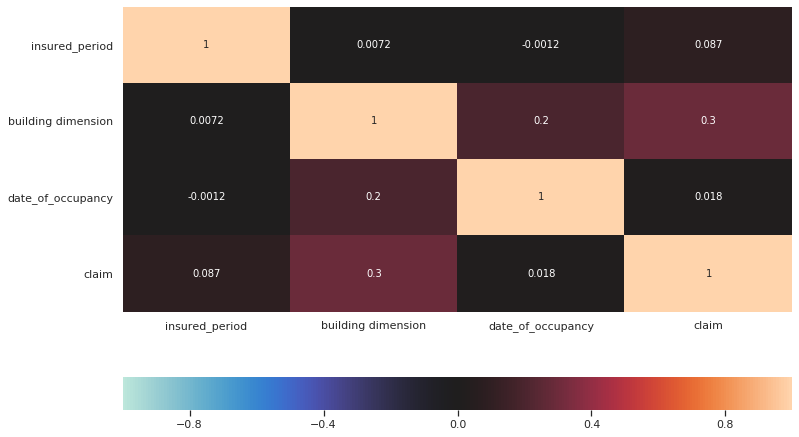

In [12]:
# построю матрицу корреляций

sns.heatmap(df[num+['claim']].corr(), annot=True, vmin=-1, vmax=1, center= 0, cbar_kws= {'orientation': 'horizontal'});

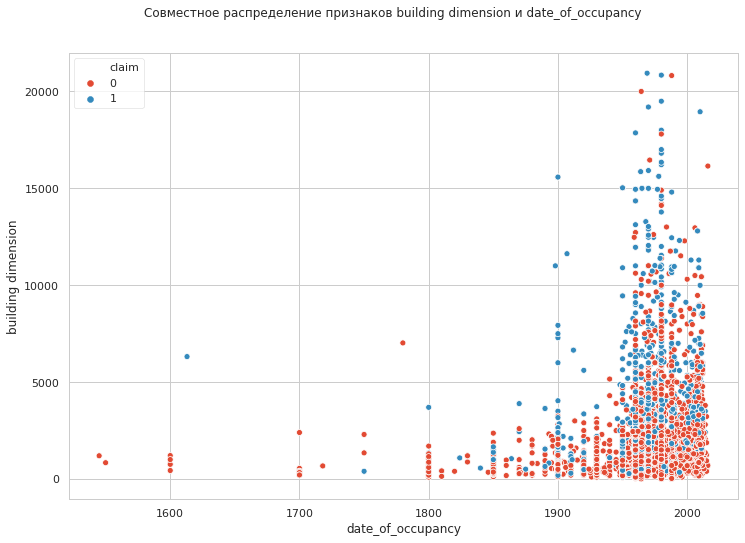

In [13]:
sns.scatterplot(x='date_of_occupancy', y='building dimension', hue='claim', data=df)
plt.subplots_adjust(top=0.9)
plt.suptitle('Совместное распределение признаков building dimension и date_of_occupancy');

Тут пока без особых инсайтов.

In [14]:
def dist_plot(data, feature, target):
    """
    Disribution plot by target values (up to 8 classes)
    :param data: pandas DataFrame
    :param feature: numerical column name, str
    :param target: target column name, str
    """
    
    matplotlib_colors = ['g', 'r', 'b', 'c', 'm', 'y', 'k', 'w']
    plt_colors = dict(zip(range(len(matplotlib_colors)), matplotlib_colors))
    
    for idx, value in enumerate(data[target].unique()):
        sns.kdeplot(data[data[target] == value][feature], label=value, color=plt_colors[idx])
    
    plt.title(f'Распределение {feature}')
    plt.show()

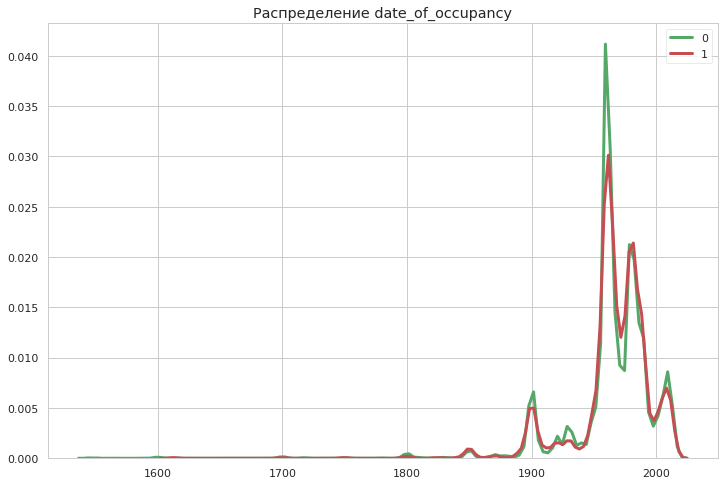

In [15]:
# date_of_occupancy

dist_plot(df, 'date_of_occupancy', 'claim')

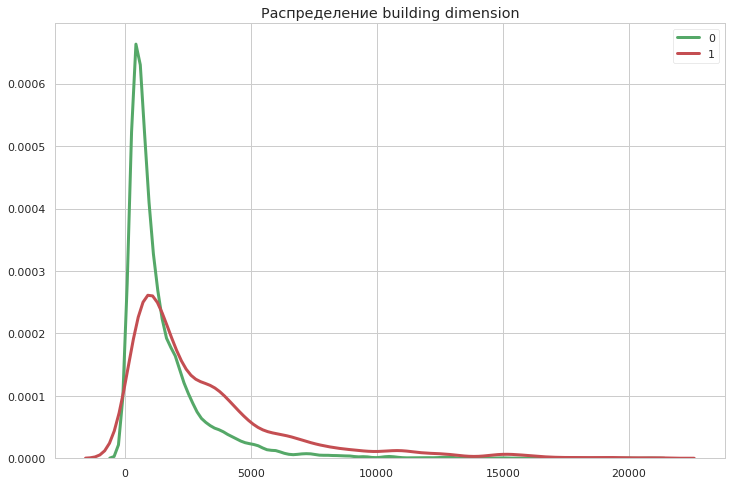

In [16]:
dist_plot(df, 'building dimension', 'claim')

Выглядит как неплохой признак.

In [17]:
# функция для категориальных переменных

def feature_stat(data, feature, target, ylim=None):
    """
    Histogram and mean value of target
    :param data: pandas DataFrame
    :param feature: feature column, str
    :param target: target column, str
    :param ylim: y axis limits 
    """
    
    # выводим долю таргета по каждой группе
    print('\033[1m{} stats: \033[0m'.format(feature))
    print()
    for value in sort(df[feature].unique()):
        print('Mean target in group {}: {:.4f}'.format(value, df[df[feature]==value][target].mean()))
        
    x = [i for i in data.groupby(feature)[target].count().index]
    y_cnt = [i for i in data.groupby(feature)[target].count().values]
    y_mean = [i for i in data.groupby(feature)[target].mean().values]
    ind = np.arange(len(data[feature].unique()))
    
    fig, ax1 = plt.subplots()
    ax1.bar(ind, y_cnt, align='center', color='royalblue', width=0.4, alpha=0.8)
    ax1.set_xlabel(feature)
    ax1.set_ylabel('count', color='b',)
    ax1.tick_params('y', colors='b')
    ax2 = ax1.twinx()
    ax2.plot(ind, y_mean, marker= 'o', linestyle='-', color='r', linewidth=5)
    ax2.set_ylabel(f'{target} mean rate', color='r')
    ax2.tick_params('y', colors='r')
    plt.xticks(ind, x)
    ax1.set_xticklabels(x, fontsize=14)
    
    if ylim:
        ax2.set_ylim(ylim)
        
    plt.title(f'{feature} and {target}', fontsize=20)
    plt.grid(False)
    plt.show()

In [18]:
# объединю группы внутри геокода

df['geo_code_short'] = df['geo_code'].apply(lambda x: x[:1])
cat.append('geo_code_short')

building_painted stats: 

Mean target in group N: 0.2064
Mean target in group V: 0.2363


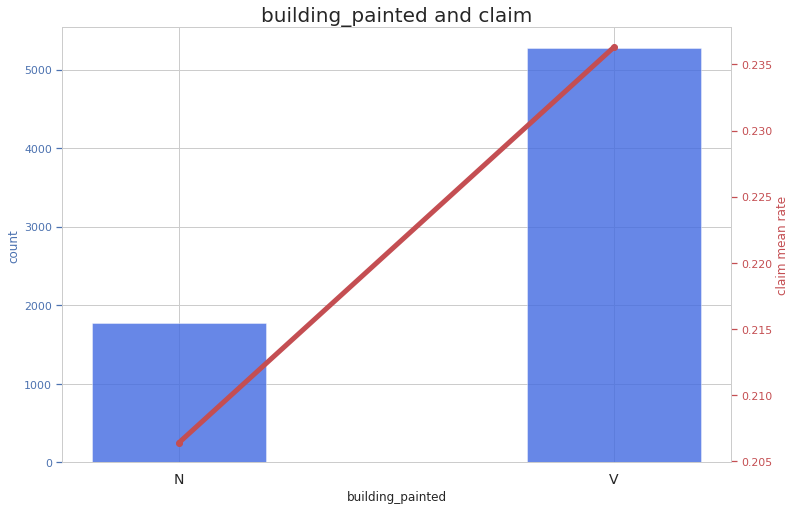

building_fenced stats: 

Mean target in group N: 0.2497
Mean target in group V: 0.2070


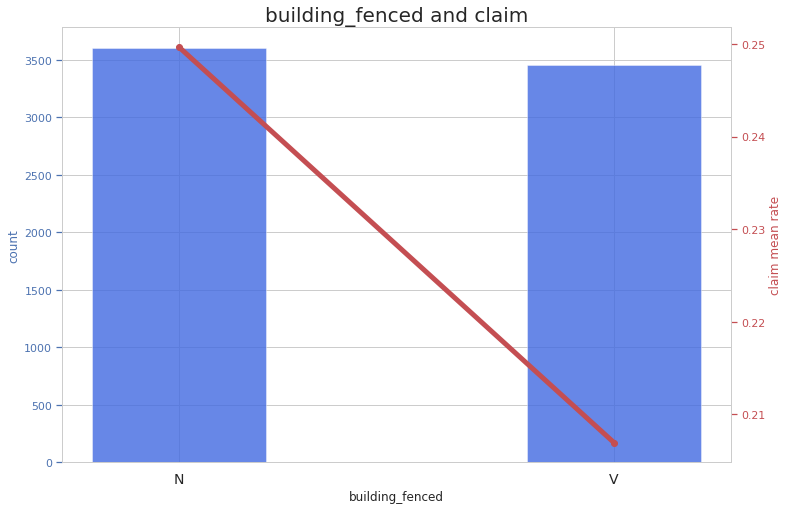

garden stats: 

Mean target in group O: 0.2499
Mean target in group V: 0.2067


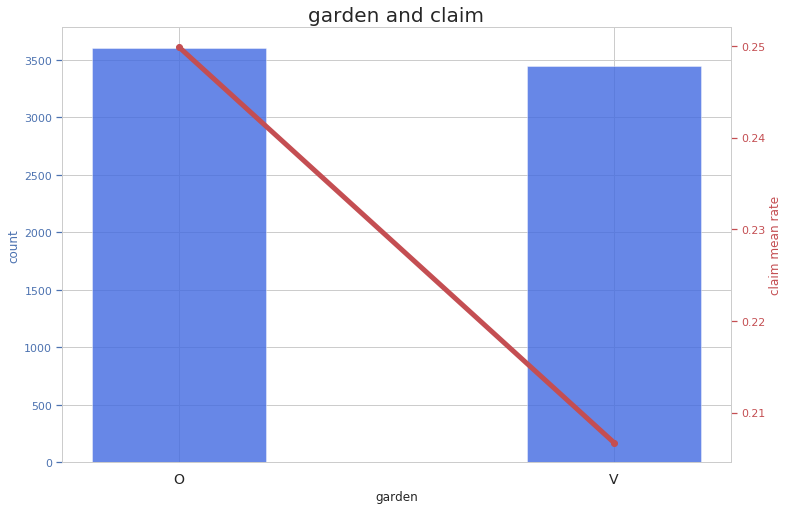

settlement stats: 

Mean target in group R: 0.2498
Mean target in group U: 0.2068


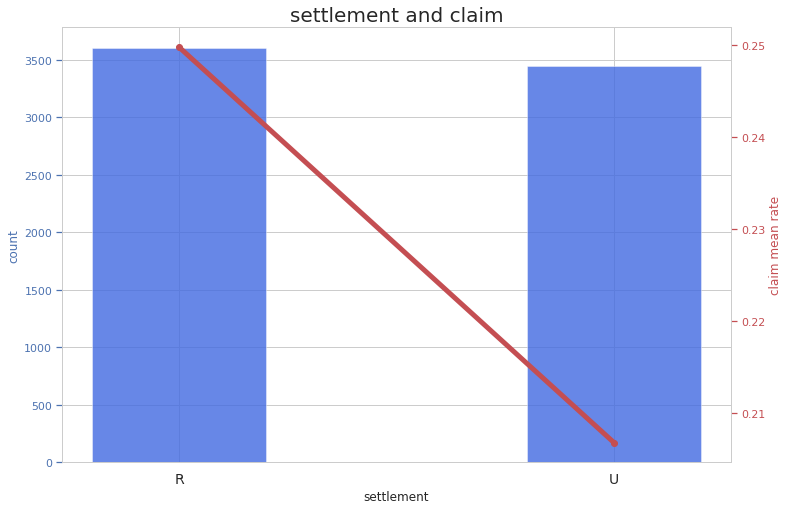

numberofwindows stats: 

Mean target in group    .: 0.2067
Mean target in group 1: 0.0933
Mean target in group 2: 0.1102
Mean target in group 3: 0.1546
Mean target in group 4: 0.2367
Mean target in group 5: 0.3003
Mean target in group 6: 0.3431
Mean target in group 7: 0.4265
Mean target in group 8: 0.4741
Mean target in group 9: 0.5102
Mean target in group >=10: 0.5224


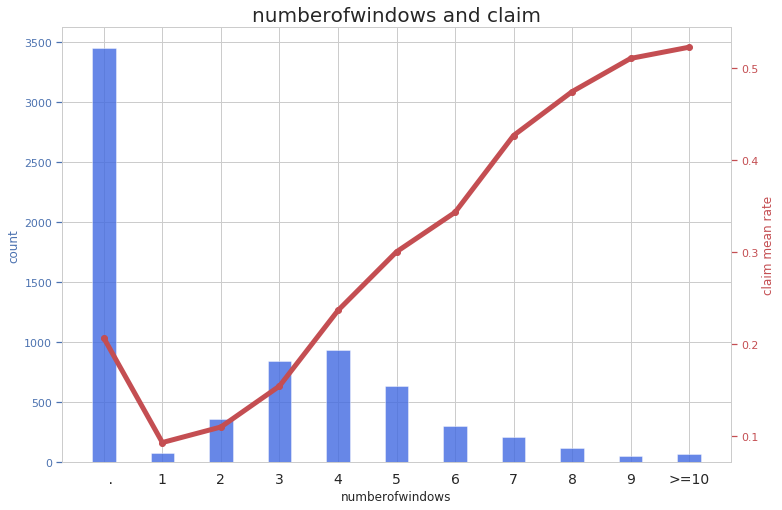

yearofobservation stats: 

Mean target in group 2012: 0.2260
Mean target in group 2013: 0.2358
Mean target in group 2014: 0.2506
Mean target in group 2015: 0.2154
Mean target in group 2016: 0.2069


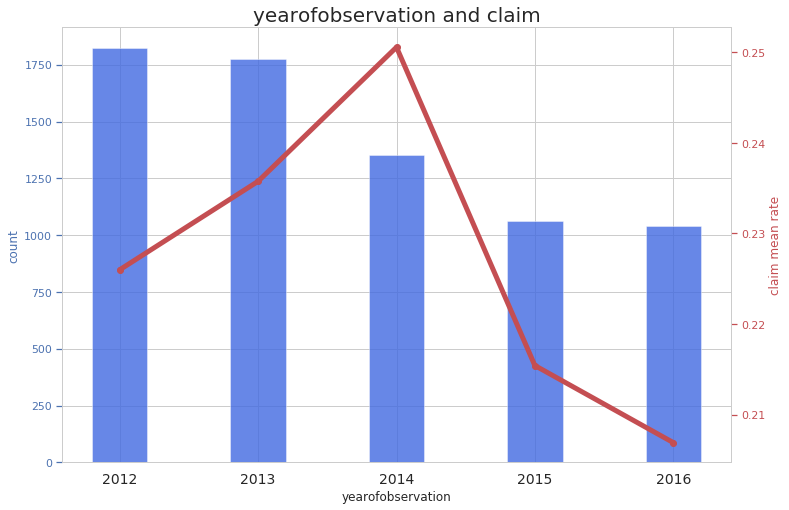

residential stats: 

Mean target in group 0: 0.2110
Mean target in group 1: 0.2693


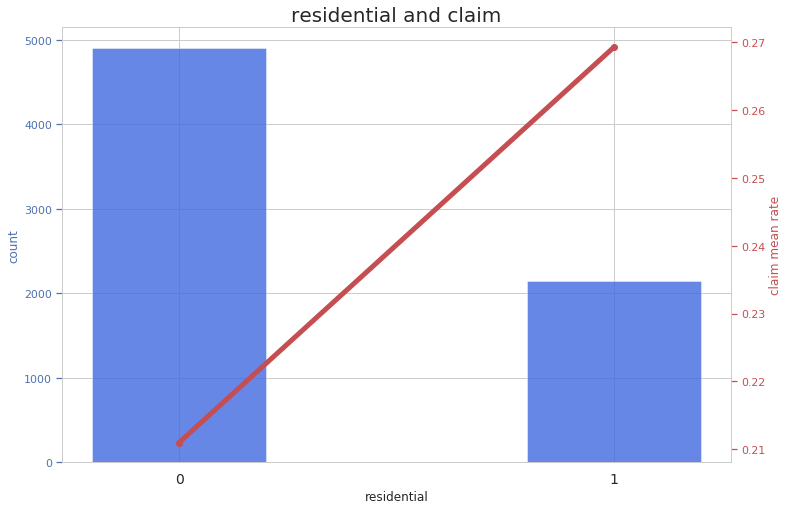

building_type stats: 

Mean target in group 1: 0.1785
Mean target in group 2: 0.2156
Mean target in group 3: 0.2514
Mean target in group 4: 0.3392


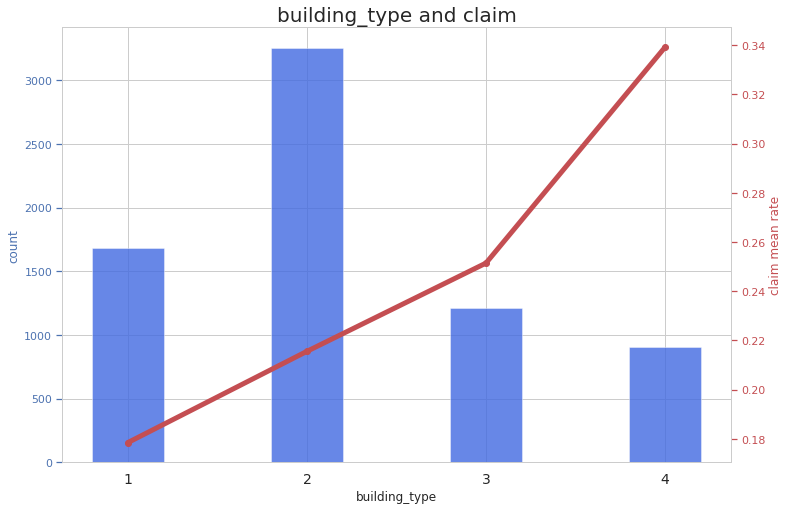

geo_code_short stats: 

Mean target in group 1: 0.2021
Mean target in group 2: 0.1990
Mean target in group 3: 0.2227
Mean target in group 4: 0.1831
Mean target in group 5: 0.2014
Mean target in group 6: 0.2421
Mean target in group 7: 0.2721
Mean target in group 8: 0.1954
Mean target in group 9: 0.2571


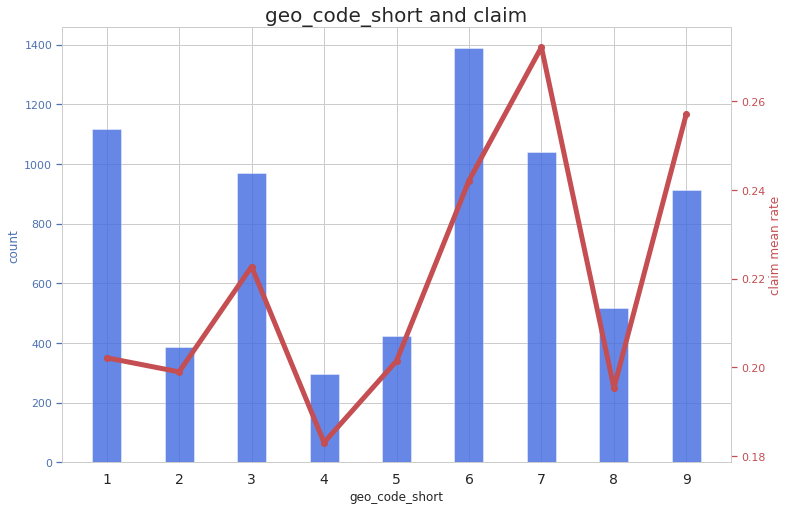

In [19]:
for column in cat:
    if column != 'geo_code':
        feature_stat(df, column, 'claim')

Довольно интересно выглядит кол-во окон и геокод.

In [20]:
# заменю '  .' на unknown 

df['numberofwindows'] = df['numberofwindows'].replace({'   .': 'unknown'})

##  2. Бейзлайн

In [21]:
# импорт библиотек

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import (train_test_split, cross_val_score, cross_val_predict,
                                     StratifiedKFold, RandomizedSearchCV, GridSearchCV)
from sklearn.metrics import accuracy_score, roc_auc_score

In [22]:
# копия исходного датасета
df_ = df.copy()

# удалю исходных признак geocode
df.drop('geo_code', axis=1, inplace=True)
cat.remove('geo_code')

# OHE для категориальных переменных
df = pd.get_dummies(df, columns=cat)

# отделю таргет и признаки
X = df.drop('claim', axis=1)
y = df['claim']


# воспроизводимость
rs = np.random.seed(0)

# разобью на трейн и валидацию
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25,
                                                      random_state=rs, stratify=y)


# стандартизация данных
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)

In [23]:
def cross_validation(classifier, X_train, y_train, cv=3, scoring='accuracy'):
    """
    Cross-validation for classification problem
    :param classifier: sklearn-compatible classifier
    :param X_train: matrix of features
    :param y_train: array of labels
    :param cv: number of cross-validation splits
    :param scoring: evaluation parameter
    """
    
    # название модели для красивого вывода
    clf_name = str(classifier)
    try:
        clf_name = clf_name[:clf_name.index('(')]
    except ValueError:
        pass
    cv_scores = cross_val_score(classifier, X_train, y_train, scoring=scoring, cv=cv)
    mean_score = np.abs(np.mean(cv_scores))
    print(f'Среднее значение \033[1m{scoring}\033[0m для {clf_name} на валидации: \033[1m{mean_score:.4f}\033[0m')
    
    
def fit_evaluate(classifier, X_train, X_test, y_train, y_test,
                 multiclass=False,
                 metric=accuracy_score):
    """
    Fits classifier on train data, evaluates on test
    :param classifier: sklearn-compatible classifier
    :param X_train: matrix of train features
    :param y_train: array of train labels
    :param X_test: matrix of test features
    :param y_test: array of test labels
    :param metric: sklearn-compatible metric function
    """
    
    # название модели для красивого вывода
    clf_name = str(classifier)
    try:
        clf_name = clf_name[:clf_name.index('(')]
    except ValueError:
        pass
    
    # название метрики 
    metric_name = str(metric)
    metric_name = metric_name[metric_name.index(' ')+1:metric_name.index(' at')]
    classifier.fit(X_train, y_train)
    if multiclass:
        predictions = classifier.predict_proba(X_test)
    else:
        predictions = classifier.predict_proba(X_test)[:, 1]
    print('Среднее значение \033[1m{}\033[0m для {} на отложенной выборке: \033[1m{:.4f}\033[0m'.format(
        metric_name, clf_name, metric(y_test, predictions)))

In [24]:
# логистическая регрессия
logit = LogisticRegression(solver='lbfgs',random_state=rs, n_jobs=-1)

# кросс-валидация
cross_validation(logit, X_train, y_train, cv=5, scoring='roc_auc')

# отложенная выборка
fit_evaluate(logit, X_train, X_valid, y_train , y_valid, multiclass=False, metric=roc_auc_score)

Среднее значение roc_auc для LogisticRegression на валидации: 0.7138
Среднее значение roc_auc_score для LogisticRegression на отложенной выборке: 0.6960


In [25]:
# KNN
knn = KNeighborsClassifier()

# кросс-валидация
cross_validation(knn, X_train, y_train, cv=5, scoring='roc_auc')

# отложенная выборка
fit_evaluate(knn, X_train, X_valid, y_train , y_valid, multiclass=False, metric=roc_auc_score)

Среднее значение roc_auc для KNeighborsClassifier на валидации: 0.5809
Среднее значение roc_auc_score для KNeighborsClassifier на отложенной выборке: 0.5879


In [26]:
# RF
rf = RandomForestClassifier(random_state=rs)

# кросс-валидация
cross_validation(rf, X_train, y_train, cv=5, scoring='roc_auc')

# отложенная выборка
fit_evaluate(rf, X_train, X_valid, y_train , y_valid, multiclass=False, metric=roc_auc_score)

Среднее значение roc_auc для RandomForestClassifier на валидации: 0.6564
Среднее значение roc_auc_score для RandomForestClassifier на отложенной выборке: 0.6877


In [27]:
# бустинг
lgbm = LGBMClassifier(random_state=rs, n_jobs=-1)

# кросс-валидация
cross_validation(lgbm, X_train, y_train, cv=5, scoring='roc_auc')

# отложенная выборка
fit_evaluate(lgbm, X_train, X_valid, y_train , y_valid, multiclass=False, metric=roc_auc_score)

Среднее значение roc_auc для LGBMClassifier на валидации: 0.6895
Среднее значение roc_auc_score для LGBMClassifier на отложенной выборке: 0.6920


## Генерация новых признаков

In [28]:
def dataframe_interact(data, cat_features):
    """
    Generates dataframe with pairwise interaction of features
    :param data; pandas DataFrame
    :param cat_features: list of categorical features
    """
    df_interact = data.copy()
    df_interact[cat_features] = df_interact[cat_features].astype('str')
    for i, col1 in enumerate(cat_features):
        for j, col2 in enumerate(cat_features[i + 1:]):
            df_interact[col1 + '_' + col2] = df_interact[col1] + '_' + df_interact[col2]
    return df_interact

In [29]:
# создам датафрейм с попарными взаимодействиями
df_interact = dataframe_interact(df_.drop('geo_code', axis=1), cat)
print('Размерность датасета с попарными взаимодействиями: {}'.format(df_interact.shape))

# OHE для категориальных переменных
cat_features = df_interact.columns[df_interact.dtypes == 'object']
df_interact = pd.get_dummies(df_interact, columns=cat_features)
print('Размерность датасета с OHE и попарными взаимодействиями: {}'.format(df_interact.shape))

# отделю таргет и признаки
X_interact = df_interact.drop('claim', axis=1)
y_interact = df_interact['claim']
            
# воспроизводимость
rs = 77

# разобью данные на трейн и тест
X_train_interact, X_test_interact, y_train_interact, y_test_interact = train_test_split(
    X_interact, y_interact, test_size=0.25, random_state=rs, stratify=y_interact)

# стандартизация данных
scaler2 = StandardScaler()
scaler2.fit(X_train_interact)

X_train_interact = scaler2.transform(X_train_interact)
X_test_interact = scaler2.transform(X_test_interact)
       
print('Доля таргета в трейне: {:.4f}'.format(np.mean(y_train_interact)), end='\n')
print('Доля таргета в тесте: {:.4f}'.format(np.mean(y_test_interact)))

Размерность датасета с попарными взаимодействиями: (7051, 49)
Размерность датасета с OHE и попарными взаимодействиями: (7051, 622)
Доля таргета в трейне: 0.2288
Доля таргета в тесте: 0.2286


Проверю для всех моделей:

In [30]:
# логистическая регрессия
logit = LogisticRegression(solver='lbfgs',random_state=rs, n_jobs=-1)

# кросс-валидация
cross_validation(logit, X_train_interact, y_train_interact, cv=5, scoring='roc_auc')

# отложенная выборка
fit_evaluate(logit, X_train_interact, X_test_interact, y_train_interact,
             y_test_interact, multiclass=False, metric=roc_auc_score)

Среднее значение roc_auc для LogisticRegression на валидации: 0.6597
Среднее значение roc_auc_score для LogisticRegression на отложенной выборке: 0.6658


In [31]:
# KNN
knn = KNeighborsClassifier(n_jobs=-1)

# кросс-валидация
cross_validation(knn, X_train_interact, y_train_interact, cv=5, scoring='roc_auc')

# отложенная выборка
fit_evaluate(knn, X_train_interact, X_test_interact, y_train_interact,
             y_test_interact, multiclass=False, metric=roc_auc_score)

Среднее значение roc_auc для KNeighborsClassifier на валидации: 0.5678
Среднее значение roc_auc_score для KNeighborsClassifier на отложенной выборке: 0.5776


In [32]:
# RF
rf = RandomForestClassifier(random_state=rs, n_jobs=-1)

# кросс-валидация
cross_validation(rf, X_train_interact, y_train_interact, cv=5, scoring='roc_auc')

# отложенная выборка
fit_evaluate(rf, X_train_interact, X_test_interact, y_train_interact,
             y_test_interact, multiclass=False, metric=roc_auc_score)

Среднее значение roc_auc для RandomForestClassifier на валидации: 0.6249
Среднее значение roc_auc_score для RandomForestClassifier на отложенной выборке: 0.6126


In [33]:
# бустинг
lgbm = LGBMClassifier(random_state=rs, n_jobs=-1)

# кросс-валидация
cross_validation(lgbm, X_train_interact, y_train_interact, cv=5, scoring='roc_auc')

# отложенная выборка
fit_evaluate(lgbm, X_train_interact, X_test_interact, y_train_interact,
             y_test_interact, multiclass=False, metric=roc_auc_score)

Среднее значение roc_auc для LGBMClassifier на валидации: 0.6855
Среднее значение roc_auc_score для LGBMClassifier на отложенной выборке: 0.6989


In [34]:
# бустинг2
lgbm = XGBClassifier(random_state=rs, n_jobs=-1)

# кросс-валидация
cross_validation(lgbm, X_train_interact, y_train_interact, cv=5, scoring='roc_auc')

# отложенная выборка
fit_evaluate(lgbm, X_train_interact, X_test_interact, y_train_interact,
             y_test_interact, multiclass=False, metric=roc_auc_score)

Среднее значение roc_auc для XGBClassifier на валидации: 0.6857
Среднее значение roc_auc_score для XGBClassifier на отложенной выборке: 0.6836


## Подбор гиперпараметров

In [35]:
from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import xgboost as xgb
import lightgbm as lgbm

### Подбор гиперпараметров для логистической регрессии

Сначала подберу на базовых фичах

In [36]:
def score(params):
    solver=params['solver']['solver']
    penalty=params['solver']['penalty']
    logit=LogisticRegression(penalty=penalty, C=params['C'],
                           solver=solver, tol=params['tol'],
                           l1_ratio=params['l1_ratio'], max_iter=500)
    logit.fit(X_train, y_train)
    predictions = logit.predict_proba(X_valid)[:, 1] # .reshape((X_test.shape[0], 2))
    score = roc_auc_score(y_valid, predictions)
    return {'loss': -score, 'status': STATUS_OK}


def optimize(trials):
    space = {
        'C': hp.loguniform('x_C', -10, 1),
        'solver':  hp.choice('x_solver',[{'solver':'newton-cg', 'penalty': hp.choice('p_newton',['none','l2'])},
                                         {'solver':'lbfgs', 'penalty': hp.choice('p_lbfgs',['none','l2'])},
                                         {'solver': 'liblinear', 'penalty': hp.choice('p_lib',['l1','l2'])}, 
                                         {'solver': 'sag', 'penalty': hp.choice('p_sag',['l2','none'])}, 
                                         {'solver':'saga', 'penalty':'elasticnet'}]),
       'tol': hp.loguniform('x_tol', -13, -1),
       'l1_ratio': hp.uniform('x_l1', 0, 1)
        }
   
    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=100)
    return best

In [37]:
trials = Trials()
best_params = optimize(trials)
best_params

100%|██████████| 100/100 [00:38<00:00,  2.59trial/s, best loss: -0.7049399722668224]


{'p_lib': 0,
 'x_C': 0.013243518665871314,
 'x_l1': 0.7698076165541263,
 'x_solver': 2,
 'x_tol': 0.0013646118987344386}

In [38]:
# сохраню в оперативке обученную модель

logit = LogisticRegression(C=best_params['x_C'], solver='liblinear', penalty='l1',
                           l1_ratio=best_params['x_l1'], tol=best_params['x_tol'],
                           max_iter=500
                          )

logit.fit(X_train, y_train)
preds = logit.predict_proba(X_valid)[:, 1]
roc_auc_score(y_valid, preds)

0.7049098671726756

### XGBoost

In [39]:
def score(params):
    params['max_depth'] = int(params['max_depth'])
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_valid, label=y_valid)
    model = xgb.train(params, dtrain, params['num_round'])
    predictions = model.predict(dvalid) # .reshape((X_test.shape[0], 2))
    score = roc_auc_score(y_valid, predictions)
    return {'loss': -score, 'status': STATUS_OK}


def optimize(trials):
    space = {
             'num_round': 200,
             'learning_rate': hp.quniform('eta', 0.005, 0.05, 0.005),
             'max_depth': hp.quniform('max_depth', 3, 14, 1),
             'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
             'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
             'gamma': hp.quniform('gamma', 0.5, 1, 0.01),
             'colsample_bytree': hp.quniform('colsample_bytree', 0.4, 1, 0.05),
             #'num_class' : 2,
             'eval_metric': 'auc',
             'objective': 'binary:logistic',
             'nthread' : 32,
             'silent' : 1
             }
    
    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=100)
    return best

In [40]:
trials = Trials()
best_params = optimize(trials)
best_params

100%|██████████| 100/100 [01:07<00:00,  1.49trial/s, best loss: -0.720360166399066]


{'colsample_bytree': 0.7000000000000001,
 'eta': 0.035,
 'gamma': 0.62,
 'max_depth': 6.0,
 'min_child_weight': 1.0,
 'subsample': 0.65}

In [41]:
# приводим к корректному формату

best_params['max_depth'] = int(best_params['max_depth'])
best_params['min_child_weight'] = int(best_params['min_child_weight'])
best_params['eval_metric'] = 'auc'
best_params['objective'] = 'binary:logistic'
best_params['nthread'] = 8
best_params['silent'] = 1

# обучу sklearn-compatible классификатор
xgb_clf = XGBClassifier(n_estimators=200, **best_params)
xgb_clf.fit(X_train, y_train)
preds = xgb_clf.predict_proba(X_valid)[:, 1]
roc_auc_score(y_valid, preds)

0.720360166399066

### LGBM

In [42]:
def score(params):
    params['num_leaves'] = int(params['num_leaves'])
    params['max_depth'] = int(params['max_depth'])
    params['n_estimators'] = int(params['n_estimators'])
    params['min_child_weight'] = int(params['min_child_weight'])

    
    dtrain = lgbm.Dataset(data=X_train, label=y_train)
    model = lgbm.train(params=params,
                       train_set=dtrain,
                       #num_boost_round=params['num_boost_round']
                      )
    predictions = model.predict(X_valid) # .reshape((X_test.shape[0], 2))
    score = roc_auc_score(y_valid, predictions)
    return {'loss': -score, 'status': STATUS_OK}


def optimize(trials):
    space = {
        # 'num_boost_round': 1000,
        'class_weight': hp.choice('class_weight', [None, 'balanced']),
        # 'boosting_type': hp.choice('boosting_type', ['gbdt', 'rf', 'dart', 'goss']),
        'num_leaves': hp.quniform('num_leaves', 1, 128, 2),
        'learning_rate': hp.quniform('learning_rate', 0.005, 0.05, 0.005),
        'max_depth': hp.quniform('max_depth', 3, 20, 1),
        'n_estimators': hp.quniform('n_estimators', 1, 2000, 1),
        'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
        'bagging_fraction': hp.quniform('bagging_fraction', 0.5, 1, 0.1),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
        'eval_metric': 'auc',
        'objective': 'binary',
        'num_threads': 32
    }
    
    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=100)
    return best

In [43]:
trials = Trials()
best_params = optimize(trials)
best_params

100%|██████████| 100/100 [05:13<00:00,  3.14s/trial, best loss: -0.713762589403007]


{'bagging_fraction': 0.8,
 'class_weight': 0,
 'colsample_bytree': 0.4721701013441102,
 'learning_rate': 0.03,
 'max_depth': 4.0,
 'min_child_weight': 2.0,
 'n_estimators': 496.0,
 'num_leaves': 4.0}

In [49]:
# приводим к корректному формату
best_params['num_leaves'] = int(best_params['num_leaves'])
best_params['max_depth'] = int(best_params['max_depth'])
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['min_child_weight'] = int(best_params['min_child_weight'])
best_params['class_weight'] = None

# best_params['num_boost_round'] = 1000
best_params['eval_metric'] = 'auc'
best_params['objective'] = 'binary'
best_params['num_threads'] = 32

In [50]:
# обучу sklearn-compatible классификатор
lgbm_sk = LGBMClassifier(**best_params)

lgbm_sk.fit(X_train, y_train)
preds = lgbm_sk.predict_proba(X_valid)[:, 1]
roc_auc_score(y_valid, preds)

0.713762589403007

### CatBoost

import catboost
from catboost import CatBoost, CatBoostClassifier, Pool

dtrain = catboost.Pool(X_train, y_train)

params = {'loss_function': 'Logloss', 'eval_metric': 'AUC',
              'num_boost_round':1000, 'learning_rate': 0.01,
              'silent': True, 'thread_count': 32,
              'subsample': 0.7
             }

ctb = CatBoost(params=params)

ctb.fit(dtrain)

In [54]:
import catboost
from catboost import CatBoost, CatBoostClassifier, Pool

def score(params):
    params['max_depth'] = int(params['max_depth'])
    params['l2_leaf_reg'] = int(params['l2_leaf_reg'])
    params['border_count'] = int(params['border_count'])

    model=CatBoostClassifier(iterations=200,
                             learning_rate=params['learning_rate'],
                             max_depth = params['max_depth'],
                             l2_leaf_reg=params['l2_leaf_reg'],
                             border_count=params['border_count'],
                             colsample_bylevel=params['colsample_bylevel'],
                             bagging_temperature=params['bagging_temperature'],
                             scale_pos_weight=params['scale_pos_weight'],
                             random_strength=params['random_strength'],
                             thread_count=32,
                             silent=True,
                             loss_function='Logloss', eval_metric='AUC'
                            )
    model.fit(X_train, y_train, verbose=False)
    predictions = model.predict_proba(X_valid)[:, 1]
    score = roc_auc_score(y_valid, predictions)
    return {'loss': -score, 'status': STATUS_OK}


def optimize(trials):
    space = {
        'num_boost_round': 1000,
        'learning_rate': hp.quniform('learning_rate', 0.005, 0.05, 0.005),
        'max_depth': hp.quniform('max_depth', 1, 16, 1),
        'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 10),
        'border_count': hp.uniform ('border_count', 32, 255),
        'colsample_bylevel': hp.uniform('colsample_bylevel', 0.5, 1.0),
        'bagging_temperature': hp.uniform('bagging_temperature', 0.0, 100),
        'random_strength': hp.uniform('random_strength', 0.0, 100),
        'scale_pos_weight': hp.uniform('scale_pos_weight', 1.0, 13.0), # n_negative / n_poistive
        'eval_metric': 'auc',
        'objective': 'binary',
        'num_threads' : 32
    }
    
    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=100)
    return best

In [55]:
trials = Trials()
best_params = optimize(trials)
best_params

100%|██████████| 100/100 [04:18<00:00,  2.58s/trial, best loss: -0.7153754926288133]


{'bagging_temperature': 53.987818757036294,
 'border_count': 158.78774138045844,
 'colsample_bylevel': 0.9327501426512208,
 'l2_leaf_reg': 9.294237777152361,
 'learning_rate': 0.04,
 'max_depth': 6.0,
 'random_strength': 76.09555948091968,
 'scale_pos_weight': 2.5136435128614543}

In [56]:
best_params['max_depth'] = int(best_params['max_depth'])
best_params['border_count'] = int(best_params['border_count'])
best_params['l2_leaf_reg'] = int(best_params['l2_leaf_reg'])

best_params['iterations'] = 200
best_params['silent'] = True
best_params['loss_function'] = 'Logloss'
best_params['eval_metric'] = 'AUC'

In [57]:
ctb_clf = CatBoostClassifier(**best_params)

ctb_clf.fit(X_train, y_train)
preds = ctb_clf.predict_proba(X_valid)[:, 1]
roc_auc_score(y_valid, preds)

0.7153754926288133

## Попробую XGBoost с попарными взаимодействиями

In [58]:
def score(params):
    params['max_depth'] = int(params['max_depth'])
    dtrain = xgb.DMatrix(X_train_interact, label=y_train_interact)
    dvalid = xgb.DMatrix(X_test_interact, label=y_test_interact)
    model = xgb.train(params, dtrain, params['num_round'])
    predictions = model.predict(dvalid) # .reshape((X_test.shape[0], 2))
    score = roc_auc_score(y_test_interact, predictions)
    return {'loss': -score, 'status': STATUS_OK}


def optimize(trials):
    space = {
             'num_round': 200,
             'learning_rate': hp.quniform('eta', 0.005, 0.05, 0.005),
             'max_depth': hp.quniform('max_depth', 3, 14, 1),
             'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
             'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
             'gamma': hp.quniform('gamma', 0.5, 1, 0.01),
             'colsample_bytree': hp.quniform('colsample_bytree', 0.4, 1, 0.05),
             #'num_class' : 2,
             'eval_metric': 'auc',
             'objective': 'binary:logistic',
             'nthread' : 32,
             'silent' : 1
             }
    
    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=100)
    return best

In [59]:
trials = Trials()
best_params = optimize(trials)
best_params

100%|██████████| 100/100 [03:33<00:00,  2.13s/trial, best loss: -0.7156929645307255]


{'colsample_bytree': 0.45,
 'eta': 0.045,
 'gamma': 0.61,
 'max_depth': 4.0,
 'min_child_weight': 3.0,
 'subsample': 0.55}

In [60]:
# приводим к корректному формату

best_params['max_depth'] = int(best_params['max_depth'])
best_params['min_child_weight'] = int(best_params['min_child_weight'])
best_params['eval_metric'] = 'auc'
best_params['objective'] = 'binary:logistic'
best_params['nthread'] = 8
best_params['silent'] = 1

# обучу sklearn-compatible классификатор
xgb_clf = XGBClassifier(n_estimators=200, **best_params)
xgb_clf.fit(X_train_interact, y_train_interact)
preds = xgb_clf.predict_proba(X_test_interact)[:, 1]
roc_auc_score(y_test_interact, preds)

0.7156929645307255

## Отбор признаков

Отбор признаков простым перебором.

In [61]:
import copy

def feature_selector(estimator, X, y, cv=3, scoring='accuracy'):
    """
    Simple feature selector
    :param estimator: sklearn like eatimator
    :param X: features, pandas DataFrame
    :param y: labels, pandas Series
    """
    # название модели для красивого вывода
    estimator_name = str(estimator)
    try:
        estimator_name = estimator_name[:estimator_name.index('(')]
    except ValueError:
        pass
    
    # формируем список признаков
    features = list(X.columns)
    
    # сохраняем результат на всех фичах
    best_score = np.mean(cross_val_score(estimator, X, y, cv=cv, scoring=scoring))
    best_features = features.copy()
    
    for column in tqdm(features):
        estimator_ = copy.deepcopy(estimator)
        if column in best_features:
            best_features.remove(column)
            score = np.mean(cross_val_score(estimator_, X[best_features], y, cv=cv, scoring=scoring))
            # если результат ухудшился, возвращаем признак в список
            if score < best_score:
                best_features.append(column)
            else:
                best_score = score
    print(f'Best score of {estimator_name} is {best_score:.4f}')
    
    # обучаем классификатор на полученных фичах
    estimator_.fit(X[best_features], y)
    
    return estimator_, best_features

In [62]:
# приведем признаки обратно к пандас для удобства работы с признаками
X_train = pd.DataFrame(X_train, columns=X.columns, index=y_train.index)
X_valid = pd.DataFrame(X_valid, columns=X.columns, index=y_valid.index)


# получаем обученные модели и их лучшие признаки
best_logit, logit_best_features = feature_selector(logit, X_train, y_train, cv=5, scoring='roc_auc')
best_xgb, xgb_best_features = feature_selector(xgb_clf, X_train, y_train, cv=5, scoring='roc_auc')
best_lgbm, lgbm_best_features = feature_selector(lgbm_sk, X_train, y_train, cv=5, scoring='roc_auc')
best_ctb, ctb_best_features = feature_selector(ctb_clf, X_train, y_train, cv=5, scoring='roc_auc')

100%|██████████| 42/42 [00:06<00:00,  6.23it/s]


Best score of LogisticRegression is 0.7152


100%|██████████| 42/42 [00:59<00:00,  1.42s/it]


Best score of XGBClassifier is 0.7146


  0%|          | 0/42 [00:00<?, ?it/s]

Finished loading model, total used 496 iterations


  2%|▏         | 1/42 [00:01<00:54,  1.33s/it]

Finished loading model, total used 496 iterations


  5%|▍         | 2/42 [00:02<00:51,  1.30s/it]

Finished loading model, total used 496 iterations


  7%|▋         | 3/42 [00:03<00:51,  1.31s/it]

Finished loading model, total used 496 iterations


 10%|▉         | 4/42 [00:05<00:49,  1.32s/it]

Finished loading model, total used 496 iterations


 12%|█▏        | 5/42 [00:06<00:48,  1.30s/it]

Finished loading model, total used 496 iterations


 14%|█▍        | 6/42 [00:07<00:47,  1.32s/it]

Finished loading model, total used 496 iterations


 17%|█▋        | 7/42 [00:09<00:45,  1.31s/it]

Finished loading model, total used 496 iterations


 19%|█▉        | 8/42 [00:10<00:44,  1.30s/it]

Finished loading model, total used 496 iterations


 21%|██▏       | 9/42 [00:11<00:42,  1.28s/it]

Finished loading model, total used 496 iterations


 24%|██▍       | 10/42 [00:12<00:40,  1.28s/it]

Finished loading model, total used 496 iterations


 26%|██▌       | 11/42 [00:14<00:40,  1.29s/it]

Finished loading model, total used 496 iterations


 29%|██▊       | 12/42 [00:15<00:38,  1.28s/it]

Finished loading model, total used 496 iterations


 31%|███       | 13/42 [00:16<00:37,  1.29s/it]

Finished loading model, total used 496 iterations


 33%|███▎      | 14/42 [00:18<00:36,  1.29s/it]

Finished loading model, total used 496 iterations


 36%|███▌      | 15/42 [00:19<00:34,  1.28s/it]

Finished loading model, total used 496 iterations


 38%|███▊      | 16/42 [00:20<00:32,  1.27s/it]

Finished loading model, total used 496 iterations


 40%|████      | 17/42 [00:21<00:31,  1.25s/it]

Finished loading model, total used 496 iterations


 43%|████▎     | 18/42 [00:23<00:29,  1.23s/it]

Finished loading model, total used 496 iterations


 45%|████▌     | 19/42 [00:35<01:47,  4.69s/it]

Finished loading model, total used 496 iterations


 48%|████▊     | 20/42 [00:37<01:21,  3.70s/it]

Finished loading model, total used 496 iterations


 50%|█████     | 21/42 [00:38<01:03,  3.03s/it]

Finished loading model, total used 496 iterations


 52%|█████▏    | 22/42 [00:39<00:50,  2.50s/it]

Finished loading model, total used 496 iterations


 55%|█████▍    | 23/42 [00:41<00:40,  2.16s/it]

Finished loading model, total used 496 iterations


 57%|█████▋    | 24/42 [00:42<00:34,  1.93s/it]

Finished loading model, total used 496 iterations


 60%|█████▉    | 25/42 [00:44<00:30,  1.77s/it]

Finished loading model, total used 496 iterations


 62%|██████▏   | 26/42 [00:45<00:25,  1.61s/it]

Finished loading model, total used 496 iterations


 64%|██████▍   | 27/42 [00:46<00:22,  1.50s/it]

Finished loading model, total used 496 iterations


 67%|██████▋   | 28/42 [00:47<00:19,  1.41s/it]

Finished loading model, total used 496 iterations


 69%|██████▉   | 29/42 [00:49<00:18,  1.41s/it]

Finished loading model, total used 496 iterations


 71%|███████▏  | 30/42 [00:50<00:16,  1.39s/it]

Finished loading model, total used 496 iterations


 74%|███████▍  | 31/42 [00:51<00:14,  1.36s/it]

Finished loading model, total used 496 iterations


 76%|███████▌  | 32/42 [00:53<00:13,  1.35s/it]

Finished loading model, total used 496 iterations


 79%|███████▊  | 33/42 [00:54<00:11,  1.33s/it]

Finished loading model, total used 496 iterations


 81%|████████  | 34/42 [00:55<00:10,  1.31s/it]

Finished loading model, total used 496 iterations


 83%|████████▎ | 35/42 [00:57<00:09,  1.39s/it]

Finished loading model, total used 496 iterations


 86%|████████▌ | 36/42 [00:58<00:08,  1.38s/it]

Finished loading model, total used 496 iterations


 88%|████████▊ | 37/42 [00:59<00:06,  1.36s/it]

Finished loading model, total used 496 iterations


 90%|█████████ | 38/42 [01:01<00:05,  1.35s/it]

Finished loading model, total used 496 iterations


 93%|█████████▎| 39/42 [01:02<00:04,  1.34s/it]

Finished loading model, total used 496 iterations


 95%|█████████▌| 40/42 [01:03<00:02,  1.33s/it]

Finished loading model, total used 496 iterations


 98%|█████████▊| 41/42 [01:05<00:01,  1.33s/it]

Finished loading model, total used 496 iterations


100%|██████████| 42/42 [01:06<00:00,  1.58s/it]


Best score of LGBMClassifier is 0.7184


100%|██████████| 42/42 [05:05<00:00,  7.27s/it]


Best score of <catboost.core.CatBoostClassifier object at 0x7f7354560ef0> is 0.7262


## Стэкинг

In [63]:
class Stacking(BaseEstimator, ClassifierMixin):
    def __init__(self, models, meta_algorithm):
        self.models = models
        self.meta_algorithm = meta_algorithm
        self.features = [None for i in range(len(models))]
        
    def fit(self, X, y, features=None, cv=5, scoring='accuracy', random_state=None):
        """
        Fit base algotithms on training data and meta-algotithm on validation data.
        :param X_train: train features, pandas DataFrame
        :param X_valid: validation features, pandas DataFrame
        :param y_train: train labels, pandas Series
        :param y_valid: validation labels, pandas Series
        :param cv: cross-validation folds, int
        :param scoring : scoring metric, str
        :param random_state: random state
        """
        # списки признаков
        if features is None:
            self.features = [list(X.columns) for _ in range(len(self.models))]
        else:
            self.features = features
        
        # матрица метапризнаков
        self.meta_features = 0.001*np.random.randn(X.shape[0], len(self.models))
        
        for idx, clf in enumerate(self.models):
            # oob-ответы базовых алгоритмов
            self.meta_features[:, idx] += cross_val_predict(clf, X[self.features[idx]], y, cv=cv,
                                                   n_jobs=-1, method='predict_proba')[:, 1]
            # обучаем базовый алгоритм
            clf.fit(X[self.features[idx]], y)
        # обучаем метаалгоритм на ответах базовых
        self.meta_algorithm.fit(self.meta_features, y)
        return self
    
    def predict(self, X, predict_type='regression'):
        """
        Makes predictions for StackingClassifier
        :param X: test features, pandas DataFrame
        """
        # матрица метапризнаков
        x_meta = np.zeros((X.shape[0], len(self.models)))
        
        # заполняем матрицу метапризнаков
        for idx, clf in enumerate(self.models):
                x_meta[:, idx] = clf.predict_proba(X[self.features[idx]])[:, 1]
        
        if predict_type == 'regression':
            predictions = self.meta_algorithm.predict(x_meta)
        if predict_type == 'classification':
            predictions = self.meta_algorithm.predict_proba(x_meta)[:, 1]
        return predictions

In [64]:
# с отбором
st = Stacking(models=[logit, xgb_clf, lgbm_sk, ctb_clf],
              meta_algorithm=LogisticRegression(random_state=rs))

st_clf = st.fit(X_train, y_train,
                features=[logit_best_features, xgb_best_features,
                         lgbm_best_features, ctb_best_features],
                cv=5, scoring='roc_auc', random_state=rs)

preds_st = st_clf.predict(X_valid, predict_type='classification')
print(f'Stacking ROC-AUC is {roc_auc_score(y_valid, preds_st):.4f}')

Stacking ROC-AUC is 0.7152


In [65]:
# с попарными пересечениями
# приведем признаки обратно к пандас для удобства работы с признаками
X_train_interact = pd.DataFrame(X_train_interact, columns=X_interact.columns, index=y_train_interact.index)
X_test_interact = pd.DataFrame(X_test_interact, columns=X_interact.columns, index=y_test_interact.index)


st = Stacking(models=[best_xgb, best_lgbm, best_ctb],
              meta_algorithm=LogisticRegression(random_state=rs))

st_clf = st.fit(X_train_interact, y_train_interact,
                features=[xgb_best_features, lgbm_best_features, ctb_best_features],
                cv=5, scoring='roc_auc', random_state=rs)

preds_st = st_clf.predict(X_test_interact, predict_type='classification')
print(f'Stacking ROC-AUC is {roc_auc_score(y_test_interact, preds_st):.4f}')

Stacking ROC-AUC is 0.7177


In [66]:
# без отбора признаков
st = Stacking(models=[logit, xgb_clf, lgbm_sk, ctb_clf],
              meta_algorithm=LogisticRegression(random_state=rs))

st_clf = st.fit(X_train, y_train,
                features=None,
                cv=5, scoring='roc_auc', random_state=rs)

preds_st = st_clf.predict(X_valid, predict_type='classification')
print(f'Stacking ROC-AUC is {roc_auc_score(y_valid, preds_st):.4f}')

Stacking ROC-AUC is 0.7176


## Подготовка сабмишена

In [67]:
# читаем данные
test_data = pd.read_csv(os.path.join('data', 'test_data.csv'))

# приведу названия столбцов к нижнему регистру для удобства
test_data.columns = [str.lower(column) for column in test_data.columns]

test_data.head()

,customer id,yearofobservation,insured_period,residential,building_painted,building_fenced,garden,settlement,building dimension,building_type,date_of_occupancy,numberofwindows,geo_code
0,H11920,2013,1.000000,0,V,N,O,R,300.0,1,1960.0,3,3310
1,H11921,2016,0.997268,0,V,N,O,R,300.0,1,1960.0,3,3310
2,H9805,2013,0.369863,0,V,V,V,U,790.0,1,1960.0,.,3310
3,H7493,2014,1.000000,0,V,N,O,R,1405.0,1,2004.0,3,3321
4,H7494,2016,1.000000,0,V,N,O,R,1405.0,1,2004.0,3,3321


In [68]:
test_data.isnull().sum()

customer id             0
yearofobservation       0
insured_period          0
residential             0
building_painted        0
building_fenced         0
garden                  4
settlement              0
building dimension     13
building_type           0
date_of_occupancy     728
numberofwindows         0
geo_code               13
dtype: int64

In [69]:
# заполню средним 

for column in tqdm(['date_of_occupancy', 'building dimension']):
    fill_na(test_data, column, np.mean)

100%|██████████| 2/2 [00:00<00:00, 278.17it/s]


In [70]:
# найду наиболее популярную категорию по признакам где есть пропуски

print(test_data['garden'].value_counts(normalize=True), end='\n\n')

test_data['geo_code_short'] = test_data[test_data['geo_code'].isnull()==False]['geo_code'].apply(lambda x: x[:1])
print(test_data['geo_code_short'].value_counts(normalize=True))

V    0.730832
O    0.269168
Name: garden, dtype: float64

6    0.245419
1    0.169830
7    0.124346
3    0.100785
8    0.090641
2    0.078861
5    0.078534
9    0.072644
4    0.038940
Name: geo_code_short, dtype: float64


In [71]:
# заполню пропуски самой популярной категорией

test_data['garden'].fillna('V', inplace=True)
test_data['geo_code_short'].fillna('6', inplace=True)
test_data['numberofwindows'] = test_data['numberofwindows'].replace({'   .': 'unknown'})

In [72]:
# удалю исходных признак geocode
test_data.drop('geo_code', axis=1, inplace=True)

# OHE для категориальных переменных
test_data = pd.get_dummies(test_data, columns=cat)

# отделю id и признаки
ids = test_data['customer id']
test_data = test_data.drop('customer id', axis=1)

# стандартизация
test_scaled = scaler.transform(test_data)
test_scaled = pd.DataFrame(test_scaled, columns=test_data.columns, index=ids.index)

In [73]:
# формируем прогнозы для теста

preds_test = st_clf.predict(test_scaled, predict_type='classification')
sub = pd.DataFrame({'Customer Id':ids, 'Claim': preds_test})
sub.to_csv('data/submission3.csv', index=False)